# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
raw_df = pd.read_csv('/content/drive/MyDrive/Data Science/train_nlp.csv', index_col=0)

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27481 entries, cb774db0d1 to 6f7127d9d7
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           27480 non-null  object
 1   selected_text  27480 non-null  object
 2   sentiment      27481 non-null  object
dtypes: object(3)
memory usage: 858.8+ KB


In [5]:
raw_df.describe()

,text,selected_text,sentiment
count,27480,27480,27481
unique,27480,22463,3
top,"I`d have responded, if I were going",good,neutral
freq,1,199,11118


In [6]:
raw_df.head()

,text,selected_text,sentiment
textID,,,
cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
088c60f138,my boss is bullying me...,bullying me,negative
9642c003ef,what interview! leave me alone,leave me alone,negative
358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
raw_df.isna().sum()

,0
text,1
selected_text,1
sentiment,0


In [8]:
raw_df = raw_df.dropna()

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [9]:
raw_df.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

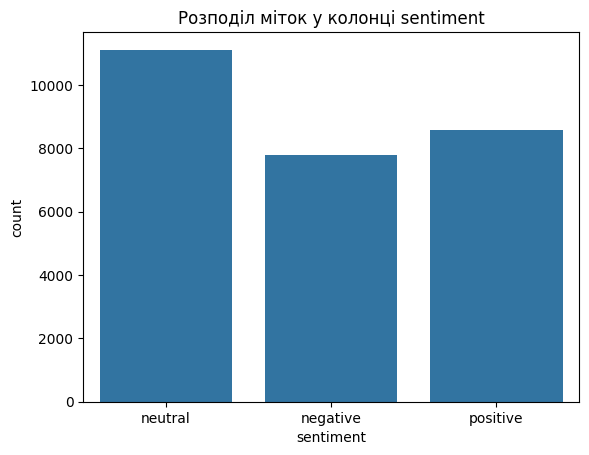

In [10]:
sns.countplot(x='sentiment', data=raw_df)
plt.title('Розподіл міток у колонці sentiment')
plt.show()

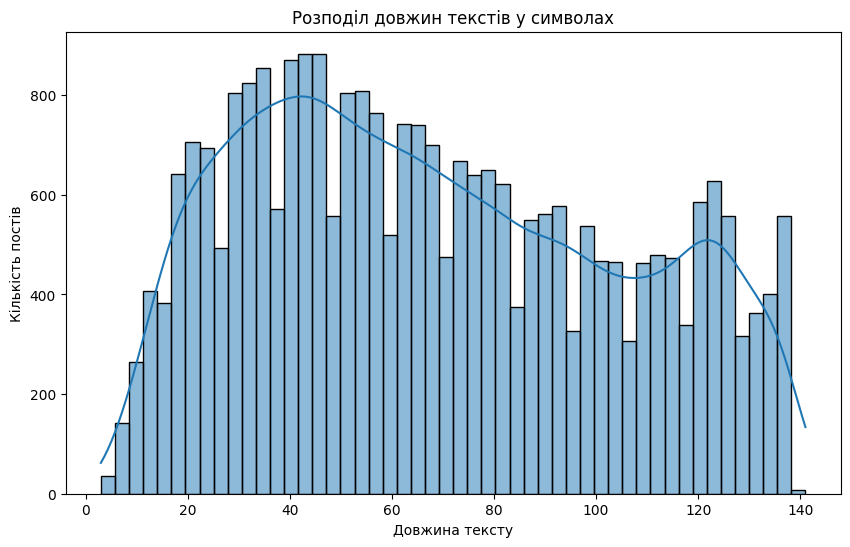


Описові статистики довжини текстів:
count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: text_length, dtype: float64


In [11]:
# Обрахунок довжини кожного тексту
raw_df['text_length'] = raw_df['text'].apply(len)

# Візуалізація розподілу довжин текстів
plt.figure(figsize=(10, 6))
sns.histplot(raw_df['text_length'], bins=50, kde=True)
plt.title('Розподіл довжин текстів у символах')
plt.xlabel('Довжина тексту')
plt.ylabel('Кількість постів')
plt.show()

# Виведення описових статистик
print("\nОписові статистики довжини текстів:")
print(raw_df['text_length'].describe())

**Висновок**: Найбільше постів
мають довжину близько
60-70 символів. Середня довжина постів
становить
68 символів
.
Медіана
(50-й процентиль) довжини постів —
64 символи. Більшість постів знаходяться в діапазоні
від 39 до 97 символів
(25-й і 75-й процентилі)

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [12]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text.lower())
    filtered_words = [stemmer.stem(word) for word in tokens if word not in stop_words and word.isalpha()]
    return ' '.join(filtered_words)

In [13]:
raw_df['processed_text'] = raw_df['text'].apply(preprocess_text)

In [14]:
vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(raw_df['processed_text'])

In [15]:
print(X.shape)
print(vectorizer.get_feature_names_out())

(27480, 1000)
['abl' 'absolut' 'access' 'account' 'ach' 'act' 'actual' 'ad' 'add'
 'addict' 'afraid' 'afternoon' 'age' 'ago' 'agre' 'ah' 'ahh' 'ahhh' 'aint'
 'air' 'airport' 'album' 'almost' 'alon' 'along' 'alot' 'alreadi'
 'alright' 'also' 'although' 'alway' 'amaz' 'american' 'anim' 'annoy'
 'anoth' 'answer' 'anymor' 'anyon' 'anyth' 'anytim' 'anyway' 'apart' 'app'
 'appar' 'appl' 'appreci' 'arent' 'arm' 'around' 'arriv' 'art' 'ask'
 'asleep' 'ate' 'attempt' 'avail' 'aw' 'awak' 'away' 'awesom' 'aww' 'awww'
 'babe' 'babi' 'back' 'bad' 'bag' 'ball' 'band' 'bank' 'bar' 'bare' 'bbq'
 'bc' 'bday' 'beach' 'beat' 'beauti' 'becom' 'bed' 'beer' 'behind'
 'believ' 'best' 'bet' 'better' 'bgt' 'big' 'bike' 'bill' 'bird'
 'birthday' 'bit' 'black' 'blackberri' 'bless' 'block' 'blog' 'blood'
 'bloodi' 'blue' 'bodi' 'boo' 'book' 'bore' 'bottl' 'bought' 'bout' 'box'
 'boy' 'boyfriend' 'brain' 'break' 'breakfast' 'bring' 'bro' 'broke'
 'broken' 'brother' 'btw' 'bug' 'bum' 'burn' 'bus' 'busi' 'buy' 'bye'

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [16]:
y = raw_df['sentiment']

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [17]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_bow, y_train)
y_pred_lr = lr_model.predict(X_test_bow)

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_bow, y_train)
y_pred_dt = dt_model.predict(X_test_bow)

# Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_bow, y_train)
y_pred_gb = gb_model.predict(X_test_bow)


def print_report(y_test, y_pred, model_name):
    print(f"Results for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

print_report(y_test, y_pred_lr, "Logistic Regression")
print_report(y_test, y_pred_dt, "Decision Tree")
print_report(y_test, y_pred_gb, "Gradient Boosting")

Results for Logistic Regression:
              precision    recall  f1-score   support

    negative       0.70      0.59      0.64      1945
     neutral       0.62      0.74      0.68      2779
    positive       0.77      0.70      0.73      2146

    accuracy                           0.68      6870
   macro avg       0.70      0.68      0.68      6870
weighted avg       0.69      0.68      0.68      6870

Accuracy: 0.6831149927219796
Results for Decision Tree:
              precision    recall  f1-score   support

    negative       0.57      0.61      0.59      1945
     neutral       0.59      0.58      0.58      2779
    positive       0.68      0.66      0.67      2146

    accuracy                           0.61      6870
   macro avg       0.61      0.62      0.61      6870
weighted avg       0.61      0.61      0.61      6870

Accuracy: 0.6120815138282387
Results for Gradient Boosting:
              precision    recall  f1-score   support

    negative       0.77      0.44 

**Висновок** : Logistic Regression класифікатор забезпечив найкращу загальну точність і збалансованість метрик серед трьох розглянутих моделей.Метрика Precision є високою для класу positive, що вказує на надійність моделі у визначенні позитивних відгуків, але для neutral і особливо для negative є місце для покращення.
Recall для negative різко нижчий за інші класи, що означає, що багато негативних відгуків модель пропускає або неправильно класифікує.Для neutral і positive класів F1-бали досить хороші (~0.68 і 0.73 відповідно), але для negative класу досі є простір для покращення.Модель Logistic Regression, загалом, робить свою роботу задовільно, але її точність і здатність правильно ідентифікувати всі класи потребують вдосконалення.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [18]:
feature_names = vectorizer.get_feature_names_out()
coefficients = lr_model.coef_

In [19]:
class_labels = ['negative', 'neutral', 'positive']


feature_importances = pd.DataFrame(coefficients.T, index=feature_names, columns=class_labels)

# найбільш значимі слова для кожного класу
top_positive_features = feature_importances['positive'].sort_values(ascending=False).head()
top_neutral_features = feature_importances['neutral'].sort_values(ascending=False).head()
top_negative_features = feature_importances['negative'].sort_values(ascending=False).head()

print("Top positive features:", top_positive_features)
print("Top neutral features:", top_neutral_features)
print("Top negative features:", top_negative_features)

Top positive features: awesom    2.532401
amaz      2.421188
cute      2.361508
thank     2.346794
love      2.287183
Name: positive, dtype: float64
Top neutral features: how         1.246518
wolverin    0.839913
guitar      0.787897
lesson      0.755502
jus         0.742172
Name: neutral, dtype: float64
Top negative features: sad      2.477658
suck     2.334764
sorri    2.174116
hate     2.172401
worst    2.102624
Name: negative, dtype: float64


**Висновок**

Позитивні ознаки:
awesom, thank, cute, amaz, love
Ці слова класично асоціюються з позитивними емоціями та враженнями.

Нейтральні слова : цей набір слів менш очевидний, але можна висунути гіпотезу, що ці слова використовуються у контекстах, які зазвичай є описовими чи розповідають про процес, що не несе явно вираженого емоційного забарвлення.

Негативні слова: ці слова зазвичай використовуються, коли висловлюється розчарування, невдоволення, антипатія чи інші негативні емоції


### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [20]:
text_data=raw_df['text']
y = raw_df['sentiment']

tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess_text)
X_tfidf = tfidf_vectorizer.fit_transform(text_data)


X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42, stratify=y)

In [21]:
lr_model_tfidf = LogisticRegression(random_state=42, max_iter=1000)
lr_model_tfidf.fit(X_train_tfidf, y_train)


predictions_tfidf = lr_model_tfidf.predict(X_test_tfidf)
print(classification_report(y_test, predictions_tfidf))
print("Accuracy:", accuracy_score(y_test, predictions_tfidf))

              precision    recall  f1-score   support

    negative       0.73      0.58      0.65      1945
     neutral       0.61      0.77      0.68      2779
    positive       0.78      0.67      0.72      2146

    accuracy                           0.68      6870
   macro avg       0.71      0.67      0.68      6870
weighted avg       0.70      0.68      0.68      6870

Accuracy: 0.6835516739446871


In [22]:
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
coefficients_tfidf = lr_model_tfidf.coef_
feature_importances_tfidf = pd.DataFrame(coefficients_tfidf.T, index=feature_names_tfidf, columns=['negative', 'neutral', 'positive'])


top_features_tfidf = {
    'positive': feature_importances_tfidf['positive'].sort_values(ascending=False).head(),
    'neutral': feature_importances_tfidf['neutral'].sort_values(ascending=False).head(),
    'negative': feature_importances_tfidf['negative'].sort_values(ascending=False).head()
}
print("Top TF-IDF Features:", top_features_tfidf)

Top TF-IDF Features: {'positive': love      7.023877
thank     6.081792
great     4.857101
awesom    4.848969
good      4.727564
Name: positive, dtype: float64, 'neutral': how       1.646357
guitar    1.249808
indoor    1.170832
relat     1.150836
differ    1.089598
Name: neutral, dtype: float64, 'negative': sad      5.401216
miss     5.255678
sorri    4.637224
hate     4.479750
suck     4.245232
Name: negative, dtype: float64}


**Висновок**:
 - Моделі демонструють досить схожі результати.
 - ця модель має вищу precision над негативними твітами
 - при порівнянні впливу токенів з попередньою моделлю можна зробити висновок що обидва набори характеристик досить добре відображають емоційний забарвлення,однак  остання модель, можливо, забезпечує більш виражену емоційну відмінність,оскільки має вищі показники TF-IDF
 - я б вибрала останню модель,оскільки вона має дещо краще показники, і виведення найвпливовіших слів мені здається більш влучне в порівнянні з попереднім.







### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [23]:
raw_df['prediction'] = lr_model_tfidf.predict(X_tfidf)

In [24]:
raw_df['prediction_proba'] = lr_model_tfidf.predict_proba(X_tfidf)[:, 1]

In [25]:
y.value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


<Axes: >

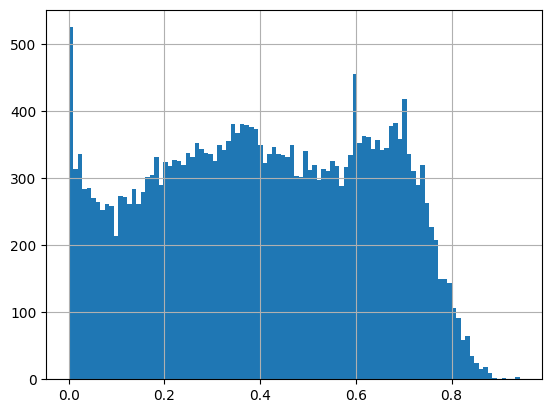

In [26]:
raw_df.prediction_proba.hist(bins=100)

In [27]:
from sklearn.metrics import accuracy_score, f1_score

In [28]:
raw_df['error'] = y != raw_df['prediction']

In [29]:
raw_df[raw_df.error & y==1]

,text,selected_text,sentiment,text_length,processed_text,prediction,prediction_proba,error
textID,,,,,,,,
9642c003ef,what interview! leave me alone,leave me alone,negative,31,interview leav alon,neutral,0.390670,True
358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,son couldnt put releas alreadi bought,neutral,0.457445,True
50e14c0bb8,Soooo high,Soooo high,neutral,10,soooo high,negative,0.279667,True
2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,107,much love hope reckon chanc minim p im never g...,positive,0.318896,True
74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,44,sharpi run danger low ink,neutral,0.618916,True
...,...,...,...,...,...,...,...,...
7fd422900b,I GET IT. YOU ESPLAINED IT TO ME AWHILE AGO.,I GET IT.,negative,46,get esplain awhil ago,neutral,0.508459,True
8f5adc47ec,http://twitpic.com/663vr - Wanted to visit the...,were too late,negative,75,want visit anim late,neutral,0.493177,True
8f14bb2715,So I get up early and I feel good about the da...,I feel good ab,positive,126,get earli feel good day walk work im feel alri...,negative,0.329075,True


- Покращити передобробку даних
У  даних видно, що текст"leave me alone" було перетворено (наприклад, "interview leav alon"). Необхідно оцінити, чи  методи лематизації або стемінгу адекватно обробляють слова, і чи не втрачаються важливі емоційні або контекстуальні значення.

- Розгляд контексту та негації
Наявність слова "not" може кардинально змінювати сенс фрази. Потрібно провести детальніший огляд чи модель правильно обробляє такий текст

- Експериментування з різними векторизаторами або числом фіч, які ми передаєм у модель.

- Додавання додаткових фіч для моделювання
Це може бути наявність певних ключових слів, довжина тексту, статистика вживання великих букв або інші метричні дані, що могли б поліпшити результати класифікації.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model